# Pyesgf tutorial:
---
### Contents:
1. CMIP file structures
2. ESGF file storage and access
3. Downloading / Processing Files
---

In [24]:
import sys
sys.path.append('/home/users/chingosa/VolcanoesHackathon/')  ### Change this
import Funcs as func
import numpy as np
import xarray as xr
import pandas as pd
import os
from concurrent.futures import ThreadPoolExecutor

from importlib import reload
reload(func)

<module 'Funcs' from '/home/users/chingosa/COASt_Hackathon_4_25/Funcs.py'>

<hr style="border:2.5px solid black">

# Section 1: CMIP File Structure

CMIP6 data is structured according to a standardized directory and filename convention to ensure consistency across modeling groups. Below is a generalized file structure outline.

### Key CMIP6 Components
- **MIP:** Model Intercomparison Project (defines the scientific experiment category)  
- **Institution:** Modeling center responsible for generating the dataset  
- **Model:** Climate model name/version  
- **Experiment:** Specific climate simulation (historical, future scenarios, etc.)  
- **Variant:** Defines different realizations of the same experiment  
- **Realm:** Component of the climate system (atmosphere, ocean, land, etc.)  
- **Variable:** Climate variable stored in the NetCDF file  
- **Grid:** Type of spatial grid used  
- **Version:** Version number of the dataset  

#### Example Filename:
tas_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc

- `tas` → Surface air temperature  
- `Amon` → Monthly averaged atmospheric data  
- `CESM2` → Model used  
- `historical` → Experiment name  
- `r1i1p1f1` → Variant label (Run 1, Initialization 1, Physics 1, Forcing 1)  
- `gn` → Native grid  
- `185001-201412` → Time range (January 1850 to December 2014)  

### 🔗 **Key Resources**

#### 📄 **CMIP6 Variable Definitions**
- **[MIP Variable Definitions](https://clipc-services.ceda.ac.uk/dreq/mipVars.html)**: A detailed list of CMIP6 variables, including descriptions and metadata.

#### 📥 **Downloading CMIP6 Data**
- **[ESGF Data Portal](https://esgf-node.llnl.gov/projects/cmip6/)**: The Earth System Grid Federation (ESGF) is the main gateway for accessing CMIP6 datasets. You can search, filter, and download data using ESGF’s interface.  
- **[CMIP6 Data at CEDA](https://data.ceda.ac.uk/badc/cmip6/)**: The Centre for Environmental Data Analysis (CEDA) hosts CMIP6 data, providing an alternative way to access and download files.

#### 🛠 **Working with CMIP6 Data in Python**
- **[ESGF Pyclient](https://esgf-pyclient.readthedocs.io/en/latest/index.html)**: A Python package for pulling data from ESGF nodes (This is what we will be using)
- **[intake-esm](https://intake-esm.readthedocs.io/en/latest/)**: A Python package for searching, indexing, and loading CMIP6 data efficiently.  
- **[xarray](https://docs.xarray.dev/en/stable/)** : A powerful Python library for handling multidimensional NetCDF files, commonly used for CMIP6 data.  
- **[cftime](https://unidata.github.io/cftime/)**: A Python package for handling CMIP6 time metadata

#### 📚 **CMIP6 Documentation**
- **[CMIP6 Guide](https://pcmdi.llnl.gov/CMIP6/Guide/modelers.html)**: Official CMIP6 guide with information on datasets, experiments, and best practices.  
- **[CMIP6 Controlled Vocabulary](https://github.com/WCRP-CMIP/CMIP6_CVs)**: A repository of CMIP6 metadata terms and controlled vocabularies used across datasets.




<hr style="border:2.5px solid black">

# Section 2: ESGF file storage and access

### Using ESGF Pyclient
We will want to be able to seach CMIP6 Model output based on: variable name, time step, model, experiment ect...

##### We can do this using the ESGF Pyclinet:

>```python
>from pyesgf.search import SearchConnection
>
># Establish Sever Connection
>conn = SearchConnection('https://esgf.ceda.ac.uk/esg-search', distrib=True)        #UK one
># conn = SearchConnection('https://esgf-data.dkrz.de/esg-search', distrib=True)    #German one
># conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True)   #US one
>os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"                          #Silence Warning
>
># Set Up Query
>query = conn.new_context(
>            project="CMIP6",     
>            experiment_id="historical",
>            source_id="CESM2",
>            frequency="mon",
>            variable_id="tas"
>        )
>```
##### Here we set up a query to send to the server to ask for files using `query.search`

>```python
>results = query.search()
>files = []
>
>for res in results:
>     hit    = res.file_context().search()
>     files += [{'model'       : model,
>                'filename'    : f.filename, 
>                'download_url': f.download_url, 
>                'opendap_url' : f.opendap_url} 
>                 for f in hit]
>
>result_df = pd.DataFrame.from_dict(files)
>```

##### This can take quite awhile depending on the number of files `query.search` finds! So to speed things up we will use a generalized parallel processing function:

>```python
>def searchFPs(conn, model, variables, tStep='day', period='SSP245'):
>    '''given model and variables looks for CMIP6 models filling criteria
>    returns as flattened df - consider saving along the way'''
>    query = conn.new_context(
>            project="CMIP6",     
>            experiment_id=period,
>            source_id=model,
>            frequency=tStep,
>            variable_id=variables
>        )
>    ## Looking for Data
>    results = query.search()
>    inputs = list(zip(results, np.repeat(model, len(results))))
>    
>    files = parallel_execution(fileContextSearch, inputs)
>    
>    flat_files = [file for sublist in files for file in sublist]
>
>    return pd.DataFrame(flat_files)
>```

---
### Trying this out

In [2]:
from pyesgf.search import SearchConnection

conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True) 
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"

model = 'GFDL-ESM4'
variables = ['tas','rsdt']
tStep = 'mon'
period = 'historical'

df = func.searchFPs(conn, model, variables, tStep=tStep, period=period)

df.head()

,model,filename,download_url,opendap_url
0,GFDL-ESM4,rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_18...,http://esgf-data1.llnl.gov/thredds/fileServer/...,http://esgf-data1.llnl.gov/thredds/dodsC/css03...
1,GFDL-ESM4,rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19...,http://esgf-data1.llnl.gov/thredds/fileServer/...,http://esgf-data1.llnl.gov/thredds/dodsC/css03...
2,GFDL-ESM4,tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...
3,GFDL-ESM4,tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...
4,GFDL-ESM4,tas_Amon_GFDL-ESM4_historical_r3i1p1f1_gr1_185...,http://esgf-data1.llnl.gov/thredds/fileServer/...,http://esgf-data1.llnl.gov/thredds/dodsC/css03...


#### Some issues with our results:

1. We don't have any of the metadata that goes along with this
2. We are getting multiple varients of the same model
3. Multiple files for different time periods
4. Multiple entries for the same file (different download/opendap)

**We want to make accessing this as easy as possible so we want:**
- One varient for each model that shares the variables of interest (ideally a low varient number)
- A way to select based off the meta data (start/end year, grid type, var ext...)
- We will save all varients of download/open dap for now

#### Varient Picker:
Its just pandas wizardry - details unimportant but here if theres interest:
<details>
  <summary><code>func.pickVarientandFilter</code></summary>

>```python
>def pickVarientandFilter(df):
>    '''This function takes a df with filenames and meta data (specifically varient ids) and finds shared varients for each model and period
>    Minimizing varient number to keep toward r1f1p1i1 although deviations in the f and p components are likely'''
>    shared_combinations = {}
>    
>    for (period, model), group in df.groupby(['period', 'model']):
>        combinations_per_variable = (
>            group.groupby('Var')[['r', 'f', 'p', 'i']]
>            .apply(lambda var_group: set(tuple(x) for x in var_group.to_numpy()))
>            .tolist()
>        )
>        if combinations_per_variable:
>            shared_combinations_for_group = set.intersection(*combinations_per_variable)
>        else:
>            shared_combinations_for_group = set()
>        shared_combinations[(period, model)] = shared_combinations_for_group
>    
>    filtered_dfs = []
>        
>    for (period, model), combinations in shared_combinations.items():
>        if combinations:  
>            first_combination = sorted(list(combinations))[0]
>            
>            filtered_df = df[
>                (df['period'] == period) & 
>                (df['model'] == model) & 
>                (df[['r', 'f', 'p', 'i']].apply(tuple, axis=1) == first_combination)
>            ]
>           filtered_dfs.append(filtered_df)
>   
>    filtered_dfs = pd.concat(filtered_dfs, ignore_index=True)
>
>    return filtered_dfs



In [11]:
## Adding Meta Data
df = func.addMetaData(df)
print(f'Varients before filtering: {df.Varient.unique()}')

## Filtering out additional Varients (Tweak if needing multiple Varients)
df_VaientPicked = func.pickVarientandFilter(df)  # Note that if there were multiple periods/models this would still work
print(f'Varients after filtering: {df_VaientPicked.Varient.unique()}')

## Save the filtered df
df_VaientPicked.to_csv(f'FPs/FPs_{model}.csv', index = None)
df_VaientPicked.head()

Varients before filtering: ['r1i1p1f1' 'r3i1p1f1' 'r2i1p1f1']
Varients after filtering: ['r1i1p1f1']


,model,filename,download_url,opendap_url,Varient,period,Var,grid,timeStep,start,stop,r,i,p,f
0,GFDL-ESM4,rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_18...,http://esgf-data1.llnl.gov/thredds/fileServer/...,http://esgf-data1.llnl.gov/thredds/dodsC/css03...,r1i1p1f1,historical,rsdt,gr1,mon,1850,1949,1,1,1,1
1,GFDL-ESM4,rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19...,http://esgf-data1.llnl.gov/thredds/fileServer/...,http://esgf-data1.llnl.gov/thredds/dodsC/css03...,r1i1p1f1,historical,rsdt,gr1,mon,1950,2014,1,1,1,1
2,GFDL-ESM4,tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...,r1i1p1f1,historical,tas,gr1,mon,1850,1949,1,1,1,1
3,GFDL-ESM4,tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_195...,http://aims3.llnl.gov/thredds/fileServer/css03...,http://aims3.llnl.gov/thredds/dodsC/css03_data...,r1i1p1f1,historical,tas,gr1,mon,1950,2014,1,1,1,1
4,GFDL-ESM4,rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_18...,http://esgf-data04.diasjp.net/thredds/fileServ...,http://esgf-data04.diasjp.net/thredds/dodsC/es...,r1i1p1f1,historical,rsdt,gr1,mon,1850,1949,1,1,1,1


##### This process can be looped over to get all files needed for your MIP analysis!

<hr style="border:2.5px solid black">

# Section 3: Data Download & Processing

### Data Access
The Earth System Grid Federation (ESGF) provides two primary ways to access CMIP6 and other climate model data: **OPeNDAP URLs** and **Download URLs**. Each serves a different purpose depending on your workflow and needs.  
- **OPeNDAP (Open-source Project for a Network Data Access Protocol)** allows users to access and manipulate climate model data **remotely** without downloading full NetCDF files.  
- **Download URL** provides a direct link to retrieve NetCDF files from ESGF nodes, allowing users to store and process data **locally**

In [18]:
## Example of Opening two files using OPeNDAP 
xr.open_mfdataset(df_VaientPicked.opendap_url[:2])

Note:Caching=1
Note:Caching=1


<xarray.Dataset> Size: 425MB
Dimensions:    (time: 1980, lat: 180, bnds: 2, lon: 288)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 2kB 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * time       (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Data variables:
    lat_bnds   (time, lat, bnds) float64 6MB dask.array<chunksize=(1200, 180, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 9MB dask.array<chunksize=(1200, 288, 2), meta=np.ndarray>
    rsdt       (time, lat, lon) float32 411MB dask.array<chunksize=(1200, 180, 288), meta=np.ndarray>
    time_bnds  (time, bnds) object 32kB dask.array<chunksize=(1200, 2), meta=np.ndarray>
Attributes: (12/47)
    external_variables:              areacella
    history:                         File was processed by fremetar (GFDL ana...
    table_id:                        Amon
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    ...                              ...
    tracking_id:                     hdl:21.14100/27947900-4b66-4b03-b1e3-2e1...
    variable_id:                     rsdt
    variant_info:                    N/A
    references:                      see further_info_url attribute
    variant_label:                   r1i1p1f1
    DODS_EXTRA.Unlimited_Dimension:  time

---
### Download URLs
ESGF data is stored on remote nodes that you can request from. individual files are frequely stored in multiple locations for redundancy sake. Unfortunely these nodes are not alway online and have different response times so keeping track of where they can be pulled reliably from is tricky. Up until this point we have kept multiple versions of the same file which is useful because odds are not all of these file locations will work.

We will use a method that attempts to download all these files concurrently and which ever one finishes first we will use (like a race). All this processing is wrapped up in `func.download_concurrently` which is used in `func.process_period_var` which is used in `func.preprocess_and_download` 


In [22]:
list(df_VaientPicked[df_VaientPicked.filename == df_VaientPicked.filename[0]].download_url.unique())

['http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/rsdt/gr1/v20190726/rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc',
 'http://esgf-data04.diasjp.net/thredds/fileServer/esg_dataroot/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/rsdt/gr1/v20190726/rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc',
 'https://esgf.ceda.ac.uk/thredds/fileServer/esg_cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/rsdt/gr1/v20190726/rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc',
 'http://esgdata.gfdl.noaa.gov/thredds/fileServer/gfdl_dataroot4/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/rsdt/gr1/v20190726/rsdt_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-194912.nc']

#### Building up our download infrastructure: 
We can start with a simple download function (from [UT-CDW](https://utcdw.physics.utoronto.ca/UTCDW_Guidebook/Chapter3/section3.4_climate_model_output_from_ESGF.html#downloading-data))

This takes a url (download url) and a file name (usually the CMIP6 filename)

>```python
>def download(url, filename):
>    """
>    A downloading script.
>    Downloads the data from the supplied URL and saves it to the specified filename.
>    """
>    import requests
>
>    r = requests.get(url, stream=True)
>    r.raise_for_status()  # Raise an error for bad HTTP responses
>    total_size, block_size = int(r.headers.get('content-length', 0)), 1024
>
>    with open(filename, 'wb') as f:
>        for data in r.iter_content(block_size):
>            f.write(data)

**We want to be able to 'race' these download processes and check that the file size is non zero**

We do this using the `func.download_concurrently` function and `func.download_and_check`
<details>
  <summary><code>func.download_concurrently</code></summary>
    
>```python
> def download_concurrently(args):
>     """This one is a mystery, takes args which are a tuple of paths (different download paths) for file i
>     it starts a new thread for each seperate path with a shared signal (Stop event) It tries to download each file simultaniously but bc each file tries to download with the same name there are temporary file names that are given. The download and check function does the actual downloading  and checking to see if the file is larger than 1kb
> 
>     When it succesfully downloads a file larger than a kb it sends the stopevent signal to end all threads it created
>     it then clears all but the sucessfully downloaded file and then renames the good file to what it was meant to be named in the first place 
>     """
> 
>     paths, i = args[0], args[1]
>     stop_event = threading.Event()  # Each call has its own stop signal
> 
>     downloadPaths = paths[paths.filename == i].reset_index(drop=True)
>     final_filename = f'TempData/{i}'
> 
>     # Create temporary filenames
>     temp_filenames = [f'TempData/{i}_temp_{idx}' for idx in range(len(downloadPaths))]
>     
>     with concurrent.futures.ThreadPoolExecutor() as executor:
>         futures = {
>             executor.submit(download_and_check, row['download_url'], temp_filename, final_filename, stop_event): (row['download_url'], temp_filename)
>             for (_, row), temp_filename in zip(downloadPaths.iterrows(), temp_filenames)
>         }
> 
>         try:
>             for future in concurrent.futures.as_completed(futures):
>                 url, temp_filename = futures[future]
>                 try:
>                     success, valid_temp_filename = future.result()
>                     
>                     if success:
>                         
>                         stop_event.set()  # Signal all threads in this batch to stop
>                         
>                         # Cancel remaining futures (prevents unstarted tasks)
>                         for f in futures:
>                             if not f.done():
>                                 f.cancel()
>                         
>                         executor.shutdown(wait=False, cancel_futures=True)  # Forcefully stop executor
>                         
>                         # Remove other temp files
>                         for other_temp_filename in temp_filenames:
>                             if other_temp_filename != valid_temp_filename and os.path.exists(other_temp_filename):
>                                 os.remove(other_temp_filename)
> 
>                         # Rename the successful download to final filename
>                         os.rename(valid_temp_filename, final_filename)
>                         return
>                 
>                 except concurrent.futures.TimeoutError:
>                     print(f"Download timed out: {url}")
>         
>         except KeyboardInterrupt:
>             print("\nInterrupted! Stopping downloads...")
>             stop_event.set()  # Signal threads in this batch to stop
>             executor.shutdown(wait=False, cancel_futures=True)  # Force shutdown
>             raise  # Re-raise to terminate execution
>         except Exception as e:
>             print(e, ' Somewhere in  download_concurrently')
>```
</details>
<details>
  <summary><code>func.download_and_check</code></summary>
    
>```python
> def download_and_check(url, temp_filename, final_filename, stop_event):
>     """Download file but stop if the event is set."""
>     try:
>         r = requests.get(url, stream=True, timeout=10)
>         r.raise_for_status()
>         
>         with open(temp_filename, "wb") as f:
>             for chunk in r.iter_content(1024):
>                 if stop_event.is_set():  # Actively check stop condition
>                     return False, None
>                 f.write(chunk)
> 
>         return True, temp_filename  # Return success flag and valid temp file
>     
>     except Exception as e:
>         return False, None
>```

</details>

##### These functions service a **single file** (ie a single variable, model, time period, experiment ect...) We frequently would want to do multiple files, variables ect...
For this we need a wrapper for the single file download infrastructure. Since for the majority of operations it is useful to have the full time series for a variable, model, period input we will define function to deal with a specific variable, model, and period.

The `func.process_period_var` function does a few things:
- identify all needed files to composite model output for that period, var, model combination
- race download the files required with `func.download_concurrently`
- Open newly downloaded dataset
- Preform a 'preprocessing step' (here we just rechunk)
- Save preprocessed data to a `TempData/` directory

>```python
> def process_period_var(period, Var, df, model, preprocessFunc):
>     """Handles downloading data for a single (period, variable) combination using download concurrently - inputs are split up by file path unique
>     """
>     paths = df[((df.model == model) & (df.period == period))&(df.Var == Var)].reset_index(drop=True)
>     saveName = f'TempData/{model}_{period}_{Var}_processed.nc'
> 
>     if not os.path.exists(saveName):  # Check if processed dataset has already been created
>         try:
>             # Prepare inputs for parallel processing of file downloads
>             inputs = [(paths, i) for i in paths.filename.unique()]
>             print(f'Downloading data for {saveName}')
>             parallel_execution(download_concurrently, inputs, processes = 8)  # Keep using multiprocessing for downloads
>             
>             # Open Raw Data
>             ds = xr.open_mfdataset(sorted([f'TempData/{fn}' for fn in paths.filename.unique()]), combine='nested', concat_dim='time', use_cftime=True)
>             ds = ds[Var]
>             # Preprocess Here: vvv
>             ds = ds.chunk({'time':-1, 'lat':20})
>             ds = preprocessFunc(ds, period, Var, df, model)
> 
>             # Save Preprossed Data
>             write_job = ds.to_netcdf(saveName, compute=False)
>             
>             with ProgressBar():
>                 print(f"Writing to {saveName}")
>                 write_job.compute()
>             for k in [f'TempData/{fn}' for fn in paths.filename]:
>                 if os.path.exists(k): os.remove(k)
>             for filename in os.listdir('TempData/'):
>                 file_path = os.path.join('TempData/', filename)
>         
>                 if ("_temp" in filename) & (os.path.getsize(file_path) < 1024):
>                     os.remove(file_path)
>         
>         except Exception as e:
>             print(e)
>```

#### Final Wrapper:
We would want to preform this step over multiple models, periods, and variables in tandum so we can use a df containing file paths of interest to preform this operation across all models and variables:

>```python
> def preprocess_and_download(models, df, preprocessFunc, maxWorkers=2):
>     ''' This is where we get a little more theoretical - Lets assume that we want to download the raw data for each of given variables and periods
>     periods - more of a relic of my own work but could be like historical or pmip'''
>     tasks = [
>         (period, Var, df, model, preprocessFunc)
>         for period in df.period.unique()
>         for Var in df.Var.unique()
>         for model in models   
>     ]
>     ## The key thing here is the process_period_var function - this will do the heavy lift for downloading and preprocessing (if we need preprocessing)
>     with ThreadPoolExecutor(max_workers=maxWorkers) as executor: ### Ramp up max worker if needed
>         executor.map(lambda args: process_period_var(*args), tasks)
>```

---
## Using download infrastructure to compare tropical mean temperatures across 2 CMIP6 models

In [28]:

conn = SearchConnection('https://esgf-node.llnl.gov/esg-search', distrib=True) 
os.environ["ESGF_PYCLIENT_NO_FACETS_STAR_WARNING"] = "on"

models = ['GFDL-ESM4', 'INM-CM5-0']

for model in models:
    variables = ['tas']
    tStep = 'mon'
    period = 'historical'
    
    df = func.searchFPs(conn, model, variables, tStep=tStep, period=period)
    df.to_csv(f'FPs/FPs_{model}.csv', index = None)
    
## Adding Meta Data
df = pd.concat([pd.read_csv(f'FPs/FPs_{model}.csv', index_col=None) for model in models])
df = func.addMetaData(df)

## Filtering out additional Varients (Tweak if needing multiple Varients)
df_VaientPicked = func.pickVarientandFilter(df)  # Note that if there were multiple periods/models this would still work


## define our preprocess
def preprocessFunc(ds, period, Var, df, model):
    return ds.sel(lat = slice(-20,20))

## Grab file paths
func.preprocess_and_download(models, df_VaientPicked, preprocessFunc)



Writing to TempData/INM-CM5-0_historical_tas_processed.nc
[###################                     ] | 48% Completed | 3.15 smsWriting to TempData/GFDL-ESM4_historical_tas_processed.nc
[########################################] | 100% Completed | 15.64 s
[########################################] | 100% Completed | 22.32 s


In [29]:
## Listing Dir to see if it worked?
os.listdir('TempData/')

['.ipynb_checkpoints',
 'TempData.txt',
 'INM-CM5-0_historical_tas_processed.nc',
 'GFDL-ESM4_historical_tas_processed.nc']

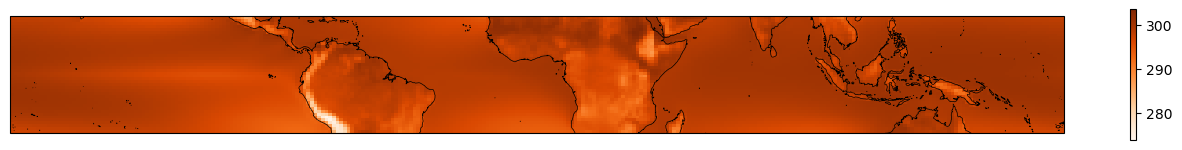

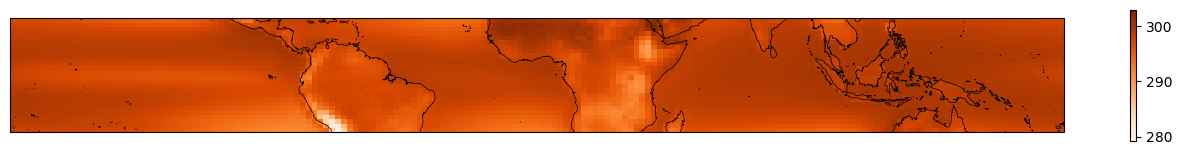

In [34]:
## Plotting to show that it worked!

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

for model in models:
    ds = xr.open_dataset(f'TempData/{model}_historical_tas_processed.nc')
    ds['tas_mean'] = ds.tas.mean('time')

    f=1.7
    fig, ax = plt.subplots(
            1, 1, figsize=(10*f, 1*f), 
            subplot_kw={'projection': ccrs.PlateCarree()}
        )
    im = ax.pcolormesh(
        ds.lon, ds.lat, ds['tas_mean'],
        transform=ccrs.PlateCarree(),
        cmap='Oranges',
    )
    ax.coastlines(linewidth=0.5)
    plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
    plt.show()

## Additional Considerations:
- If storage is an issue for preprocessed data consider chaining preprocessing and analyis steps/ further data products with a file removal script to keep space
